<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m3_CBloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll train m3 using the continuous bernoulli log loss (1907.06845) for the sake of comparison.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

from google.colab import files

In [2]:
#! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32
input_size = (img_ht,img_wd,3)

batch_size = 128

### **Loading the dataset**

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

# **Latent dim 320**

In [5]:
K.clear_session()

latent_dim = 320

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

### **The model**

In [6]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_1 (Dense)             (None, 640)               205440    
                                                                 
 re_lu_25 (ReLU)             (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 1280)              820480    
                                                                 
 re_lu_26 (ReLU)             (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              5246976   
                                                                 
 re_lu_27 (ReLU)             (None, 4096)              0   

In [8]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()


Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 320)               17197056  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         23272835  
                                                                 
Total params: 40469891 (154.38 MB)
Trainable params: 40445699 (154.29 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


### **Continuous Bernoulli loss**

In [9]:
l_cutoff = 0.495       # these are hyperparameters
u_cutoff = 0.505       # for the range of values within these limits, we shall use the taylor expansion

def norm_CB(z):                                  # the norm of the Continuous Bernoulli loss function

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    z = tf.clip_by_value(z, clip_value_min = K.epsilon(), clip_value_max = 1 - K.epsilon())     # to avoid running into inf and nan values
    z_reg = tf.where(gate, l_cutoff, z)          # this is so the norm_reg below does not evaluate at z when z is close to the problematic value of z=0.5, otherwise we get NaNs. We use the taylor expansion to compute the loss at z=0.5 anyway.


    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)         # this is the part meant to be used beyond the cutoff limits specified above
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)          # the taylor expansion that we use within the cutoff limits


    norm = tf.where(gate, norm_taylor, norm_reg)          # when an element of gate is true, the corresponding element of norm_taylor is returned, otherwise the corresponding element of norm_reg is returned

    return norm

@tf.function
def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce + tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )    # the binary cross entropy loss corrected with the normalisation factor
                                                                                    # the bce is built to average across the axes other than the batch axis, we do this for the norm manually

  return tf.reduce_mean(corrected_loss_tensor)            #  averaging across the batch axis


### **Training**

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 113s 167ms/step - loss: 1.3621 - accuracy: 0.4860 - val_loss: 1.3542 - val_accuracy: 0.4645
Epoch 2/80
391/391 [==============================] - 59s 150ms/step - loss: 1.3392 - accuracy: 0.5125 - val_loss: 1.3444 - val_accuracy: 0.5281
Epoch 3/80
391/391 [==============================] - 57s 146ms/step - loss: 1.3336 - accuracy: 0.5641 - val_loss: 1.3362 - val_accuracy: 0.5813
Epoch 4/80
391/391 [==============================] - 59s 150ms/step - loss: 1.3308 - accuracy: 0.5807 - val_loss: 1.3348 - val_accuracy: 0.6005
Epoch 5/80
391/391 [==============================] - 59s 150ms/step - loss: 1.3296 - accuracy: 0.5961 - val_loss: 1.3339 - val_accuracy: 0.5967
Epoch 6/80
391/391 [==============================] - 57s 145ms/step - loss: 1.3282 - accuracy: 0.6037 - val_loss: 1.3335 - val_accuracy: 0.6018
Epoch 7/80
391/391 [==============================] - 57s 146ms/step - loss: 1.3269 - accuracy: 0.6086 - val_loss: 1.3280 - val_a

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 90s 150ms/step - loss: 1.3144 - accuracy: 0.7402 - val_loss: 1.3186 - val_accuracy: 0.7287
Epoch 2/50
391/391 [==============================] - 57s 146ms/step - loss: 1.3143 - accuracy: 0.7404 - val_loss: 1.3190 - val_accuracy: 0.7263
Epoch 3/50
391/391 [==============================] - 58s 149ms/step - loss: 1.3143 - accuracy: 0.7406 - val_loss: 1.3191 - val_accuracy: 0.7350
Epoch 4/50
391/391 [==============================] - 58s 149ms/step - loss: 1.3142 - accuracy: 0.7409 - val_loss: 1.3192 - val_accuracy: 0.7315
Epoch 5/50
391/391 [==============================] - 61s 156ms/step - loss: 1.3142 - accuracy: 0.7406 - val_loss: 1.3185 - val_accuracy: 0.7306
Epoch 6/50
391/391 [==============================] - 58s 148ms/step - loss: 1.3142 - accuracy: 0.7411 - val_loss: 1.3194 - val_accuracy: 0.7242
Epoch 7/50
391/391 [==============================] - 61s 155ms/step - loss: 1.3141 - accuracy: 0.7427 - val_loss: 1.3194 - val_ac

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1564, decay_rate=0.75)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, start_from_epoch=9, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, callbacks=[callback])

Epoch 1/40
391/391 [==============================] - 91s 150ms/step - loss: 1.3166 - accuracy: 0.7143 - val_loss: 1.3202 - val_accuracy: 0.7155
Epoch 2/40
391/391 [==============================] - 59s 150ms/step - loss: 1.3131 - accuracy: 0.7312 - val_loss: 1.3195 - val_accuracy: 0.7215
Epoch 3/40
391/391 [==============================] - 58s 150ms/step - loss: 1.3128 - accuracy: 0.7414 - val_loss: 1.3193 - val_accuracy: 0.7288
Epoch 4/40
391/391 [==============================] - 58s 149ms/step - loss: 1.3126 - accuracy: 0.7447 - val_loss: 1.3195 - val_accuracy: 0.7325
Epoch 5/40
391/391 [==============================] - 57s 145ms/step - loss: 1.3126 - accuracy: 0.7466 - val_loss: 1.3193 - val_accuracy: 0.7326
Epoch 6/40
391/391 [==============================] - 57s 146ms/step - loss: 1.3125 - accuracy: 0.7489 - val_loss: 1.3194 - val_accuracy: 0.7340
Epoch 7/40
391/391 [==============================] - 59s 150ms/step - loss: 1.3125 - accuracy: 0.7494 - val_loss: 1.3194 - val_ac

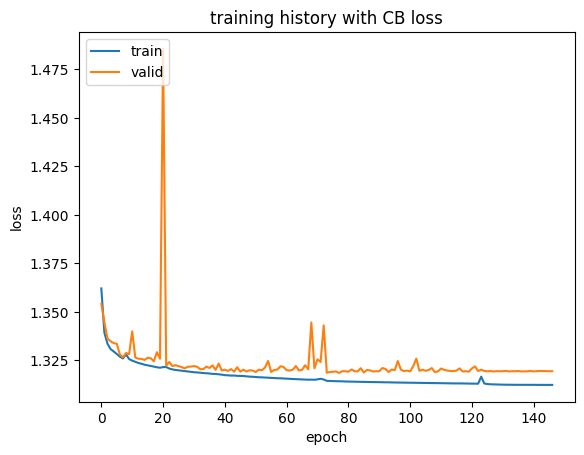

In [14]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history with CB loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_CBloss.png')
plt.show()

The training and validation set accuracy values obtained, at 75.29 and 73.65 respectively, are slightly worse as compared to when training with mse loss.

In [15]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_CBloss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Reconstructions based on the above**

In [16]:
def plot_reconstruction(set, name,seed_val, epochs, scale, model_name):

  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(np.ceil(9*scale),np.ceil(4*scale)))
  recon.suptitle(model_name + ' with latent_dim = ' + str(latent_dim) +': reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

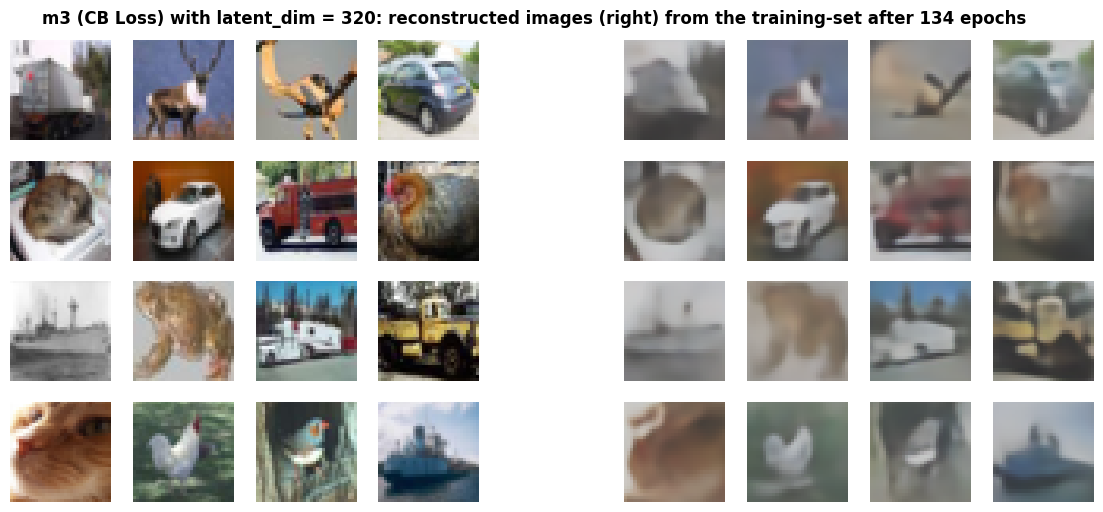

In [17]:
plot_reconstruction(img_train, 'training', 123, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_1.png')

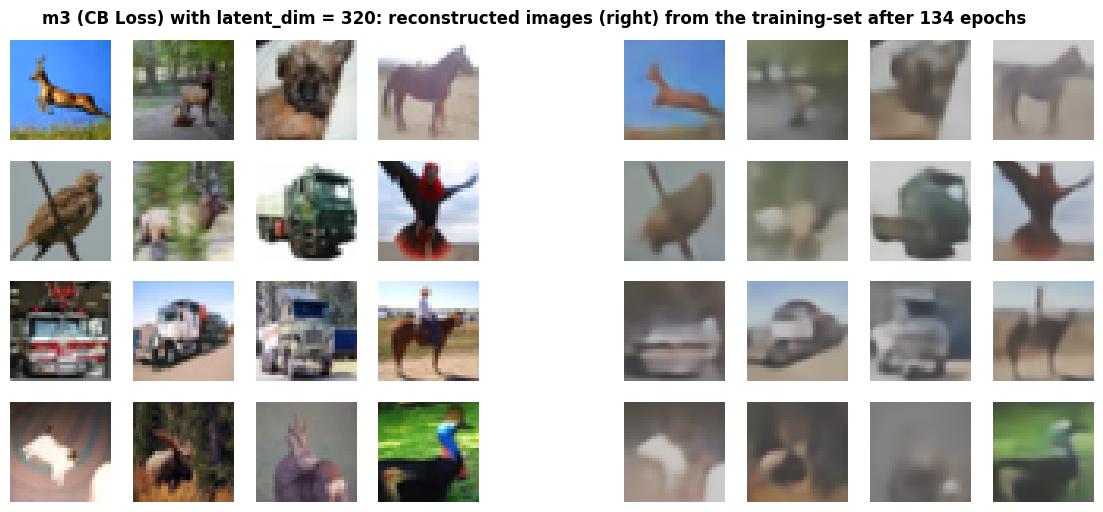

In [18]:
plot_reconstruction(img_train, 'training', 1000, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_2.png')

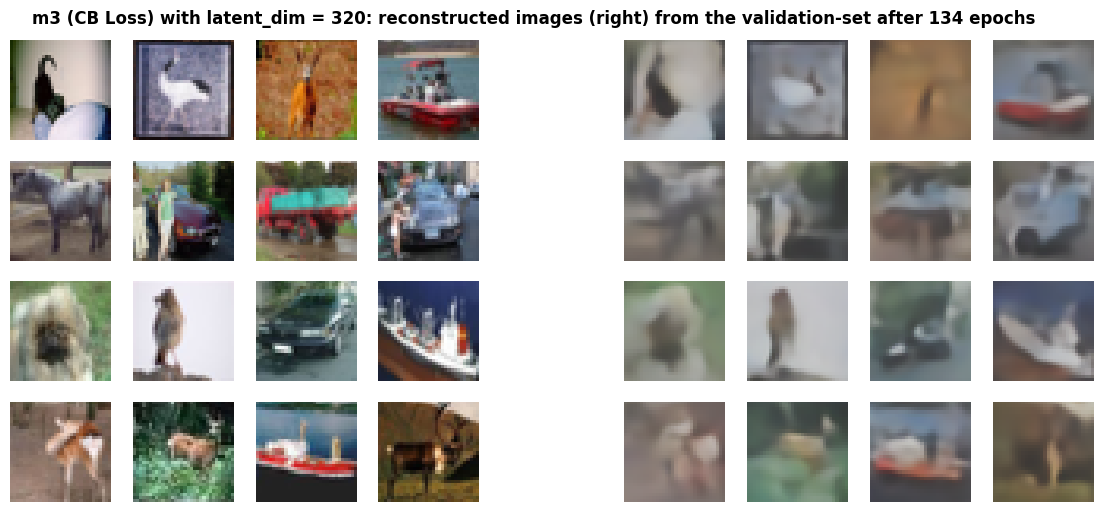

In [19]:
plot_reconstruction(img_valid, 'validation', 123, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_1.png')

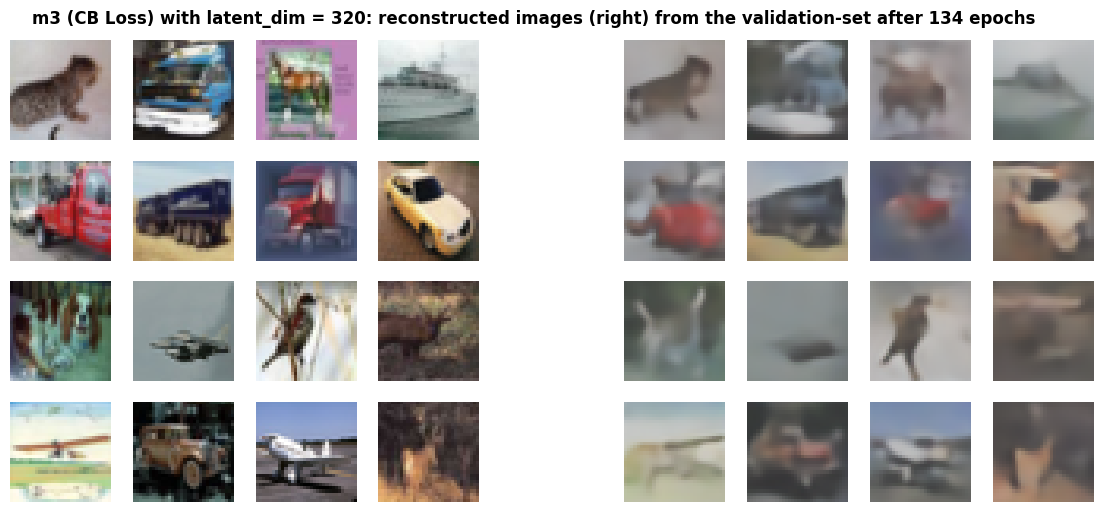

In [20]:
plot_reconstruction(img_valid, 'validation', 1000, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_2.png')

In [22]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_2.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Conclusions**

As previously observed, the colours of the generated images are washed out when we use CB loss.

### **An experiment**

We'll train the model a little further with mse loss just to see what happens.

In [23]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history_mse = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, callbacks=[callback])

Epoch 1/40
391/391 [==============================] - 102s 151ms/step - loss: 0.0061 - accuracy: 0.7466 - val_loss: 0.0096 - val_accuracy: 0.7340
Epoch 2/40
391/391 [==============================] - 56s 144ms/step - loss: 0.0051 - accuracy: 0.7515 - val_loss: 0.0096 - val_accuracy: 0.7362
Epoch 3/40
391/391 [==============================] - 58s 149ms/step - loss: 0.0050 - accuracy: 0.7522 - val_loss: 0.0094 - val_accuracy: 0.7367
Epoch 4/40
391/391 [==============================] - 57s 145ms/step - loss: 0.0050 - accuracy: 0.7538 - val_loss: 0.0095 - val_accuracy: 0.7385
Epoch 5/40
391/391 [==============================] - 58s 149ms/step - loss: 0.0050 - accuracy: 0.7540 - val_loss: 0.0096 - val_accuracy: 0.7410
Epoch 6/40
391/391 [==============================] - 58s 148ms/step - loss: 0.0049 - accuracy: 0.7553 - val_loss: 0.0095 - val_accuracy: 0.7407
Epoch 7/40
391/391 [==============================] - 58s 150ms/step - loss: 0.0049 - accuracy: 0.7559 - val_loss: 0.0094 - val_a

We end up with similar (just slightly worse) loss and accuracy as compared to training the model with mse loss from the beginning.

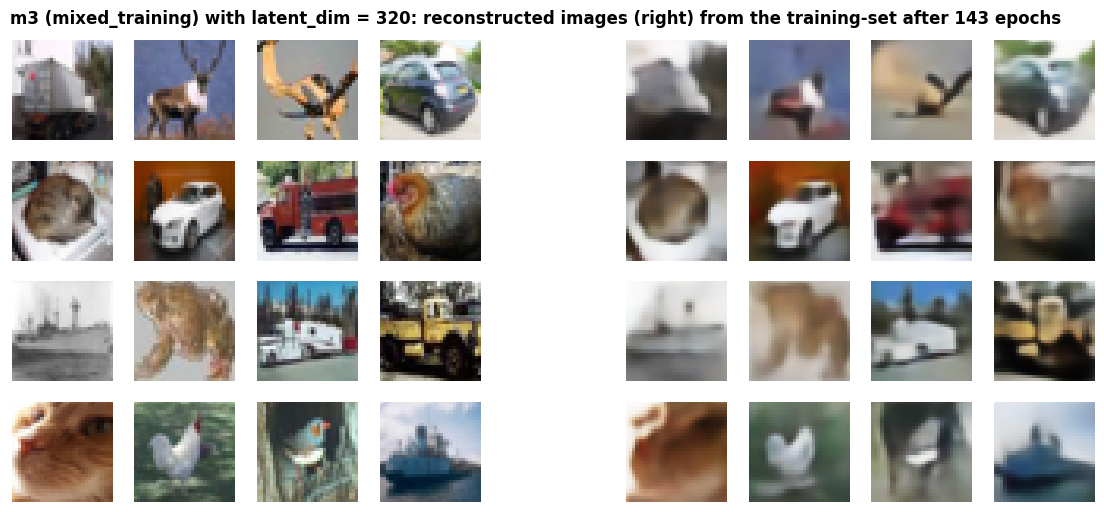

In [25]:
plot_reconstruction(img_train, 'training', 123, 143, 1.5, 'm3 (mixed_training)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_mixed_training_reconstructions_TrainSet_1.png')

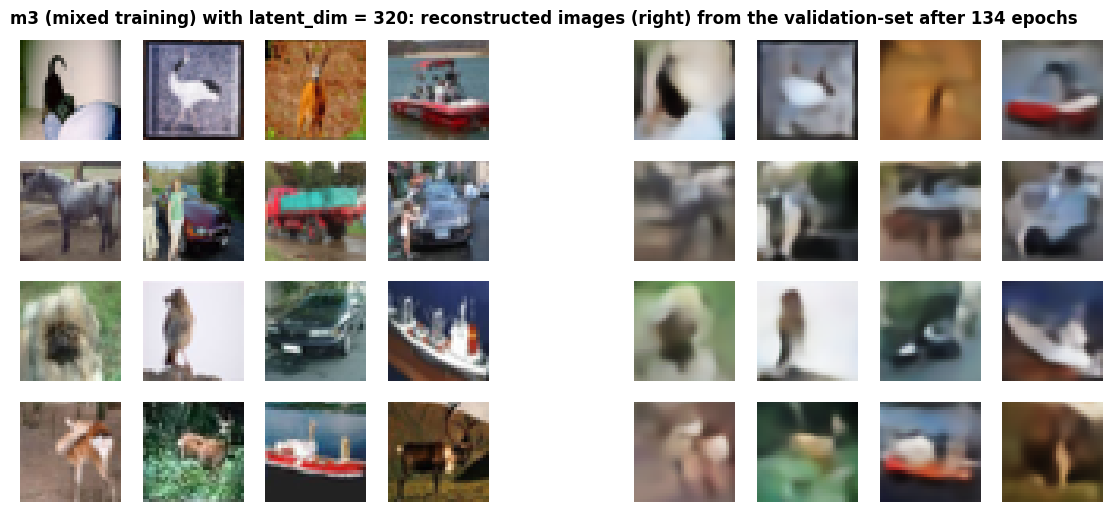

In [27]:
plot_reconstruction(img_valid, 'validation', 123, 134, 1.5, 'm3 (mixed training)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_mixed_training_reconstructions_ValidSet_1.png')

**Conclusion** : the reconstructed images now have similar quality as we had obtained training m3 with mse from the start. So it seems like the last training phase with mse brings the model closer to where we would have been if we had used mse from the beginning.

In [28]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_mixed_training_reconstructions_TrainSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_mixed_training_reconstructions_ValidSet_1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>